In [1]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.clustering import *
import intake

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dask.distributed import Client, progress
client = Client(**COMPUTE_KWARGS)

# CESM

In [2]:
from pathlib import Path
import numpy as np
import xarray as xr
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind")
paths = list(basepath.iterdir())
paths = [path for path in paths if path.suffix == ".nc" and path.name != "ds.nc"]
parts = [path.name.split(".")[0].split("-") for path in paths]
parts = np.asarray(parts)
sorted_order = np.argsort([memb.replace("r10", "r0") for memb in parts[:, 0]])
parts = parts[sorted_order]
paths = [paths[i] for i in sorted_order]
all_members = np.unique(parts[:, 0])
all_years = np.unique(parts[:, 1])

not_here = []
here = []
for year in all_years:
    for member in all_members:
        potential_path = basepath.joinpath(f"{member}-{year}.nc")
        if potential_path.is_file():
            here.append(potential_path)
        else:
            not_here.append(potential_path)
len(here)

from itertools import groupby
paths_to_load = []
valid_ensembles = []
for key, indices in groupby(range(len(parts)), lambda i: parts[i][0]):
    indices = list(indices)
    group = parts[indices]
    these_paths = [paths[i] for i in indices]
    years = np.asarray(list([g[1] for g in group]))
    if len(years) == 60:
        paths_to_load.append(these_paths)
        valid_ensembles.append(key)
    else:
        print(key, len(years))

r2i1021p1f1 30


In [3]:
ds = xr.concat([xr.open_mfdataset(ptl) for ptl in paths_to_load], dim="member")

In [4]:
import dask
from dask.distributed import progress, Client
from jetstream_hugo.definitions import COMPUTE_KWARGS
client = Client(**COMPUTE_KWARGS)
dask.persist(ds)
progress(ds, notebook=False)
ds = dask.compute(ds)
to_comp = ds[0].to_zarr(f"/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", compute=False, encoding={var: {"chunks": (-1, 100, -1, -1)} for var in ds[0].data_vars}, mode="w")
dask.persist(to_comp)
progress(to_comp, notebook=False)
dask.compute(to_comp)

# Daskify

In [38]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
ds = exp.ds

In [37]:
# path = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind")
# ds = xr.open_dataset(
#     path.joinpath("ds.zarr"), 
#     engine="zarr", 
#     chunks={"member": -1, "time": 100, "lat": -1, "lon": -1}
# )
# data_handler = DataHandler(ds, path.joinpath("results/1"))
# ds_block = ds.isel(time=slice(2)).load()

In [49]:
dummy_ds = ds.isel(time=slice(1000)).load().chunk({"time": 10, "lat": -1, "lon": -1})

In [63]:
template = dummy_ds.isel(lon=0, lat=0).reset_coords(drop=True)
basepath = Path(f"/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results/1")
dummy_ds.map_blocks(inner_find_all_jets, template=template, kwargs=dict(basepath=basepath)).compute() 

<xarray.Dataset> Size: 24kB
Dimensions:  (time: 1000)
Coordinates:
  * time     (time) datetime64[ns] 8kB 1959-01-01 ... 1959-09-07T18:00:00
Data variables:
    s        (time) float32 4kB 14.63 13.22 10.67 9.209 ... 20.13 18.88 18.19
    u        (time) float32 4kB 14.63 13.21 10.16 9.162 ... 16.83 18.25 18.03
    v        (time) float32 4kB 0.1221 0.5841 -3.268 0.924 ... 11.05 4.807 2.41
    lev      (time) float32 4kB 175.0 175.0 200.0 175.0 ... 175.0 175.0 175.0

In [119]:
dfs = []
for f in basepath.joinpath("jets").glob("*.pkl"):
    dfs.append(load_pickle(f))
df = pd.concat(dfs).sort_index(level=list(dfs[0].index.names))

In [118]:
df.loc[:, :, 0]
df[:] = 0

In [79]:
"member" in dfs[0].index.names

False

In [2]:
import xarray as xr
ds = xr.open_dataset(f"/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", engine="zarr", chunks={"member": -1, "time": 100, "lat": -1, "lon": -1})
ds = ds.reset_coords("time_bnds", drop=True)

The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.


# extreme cesm clim

In [16]:
import numpy as np
from jetstream_hugo.data import *
quantiles = ds["s"].quantile(np.arange(0.6, 1, 0.05), ["member", "lon", "lat"]).compute()
quantiles = smooth(quantiles, {"time": ("win", 15)}).load()
quantiles.to_netcdf(f"{DATADIR}/CESM2/flat_wind/results/s_q.nc")


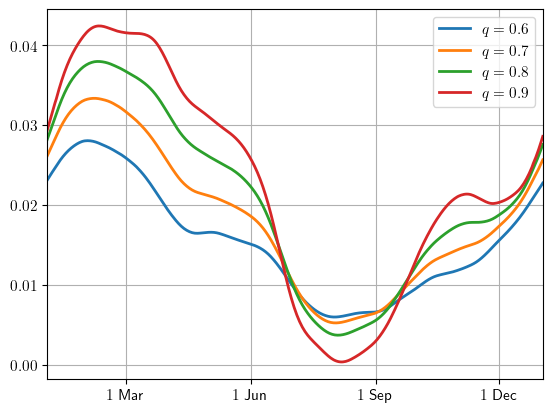

In [19]:
from matplotlib.dates import DateFormatter, MonthLocator
from jetstream_hugo.definitions import *
from scipy.stats import linregress

def get_trend(da):
    years = np.unique(da.time.dt.year)
    if "jet" not in da.dims:
        result = linregress(years, da.values)
        return xr.Dataset({"slope": result.slope, "p": result.pvalue})
    jets = da.jet.values
    slopes = xr.DataArray(np.zeros(len(jets)), coords={"jet": jets})
    pvalues = slopes.copy()
    for j, jet in enumerate(jets):
        result = linregress(years, da.isel(jet=j).values)
        slopes[j] = result.slope
        pvalues[j] = result.pvalue
    return xr.Dataset({"slope": slopes, "p": pvalues})

winsize = 15
halfwinsize = int(np.ceil(winsize / 2))

fig, ax = plt.subplots()
for q, qval in zip(quantiles[::2], np.arange(0.6, 1, 0.05 * 2)):
    gb = q.groupby("time.dayofyear")
    x = list(gb.groups)
    x = DATERANGE[x]
    ys = gb.map(get_trend) 
    ps = ys["p"]
    ys = ys["slope"]
    ys = ys.pad({"dayofyear": halfwinsize}, mode="wrap")
    ys = ys.rolling(dayofyear=winsize, center=True).mean()
    ys = ys.isel({"dayofyear": slice(halfwinsize, -halfwinsize)})
    ax.plot(x, ys, label=f"$q={qval:.1f}$", lw=2)
ax.grid(True)
ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
ax.xaxis.set_major_formatter(DateFormatter("1 %b"))
ax.set_xlim(min(x), max(x))
ax.legend()

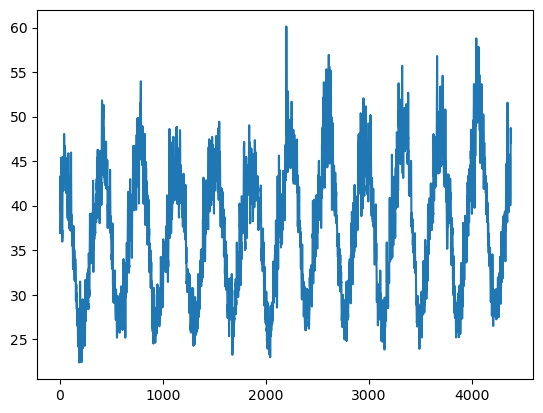

In [10]:
q_clim = compute_clim(quantiles, "dayofyear")
q_clim = smooth(q_clim, {"dayofyear": ("win", 61)}).load()
q_clim.to_netcdf(f"{DATADIR}/CESM2/flat_wind/results/s_q_clim.nc")

In [19]:
ds = ds.reset_coords("time_bnds", drop=True)

# Extreme experiment

In [ ]:
exp_tp = ExtremeExperiment(
    DataHandler("ERA5", "surf", "tp", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None),
    q = 0.95,
)
da_tp = exp_tp.da.load()

data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
exp = MultiVarExperiment(data_handlers)

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds = exp.props_as_ds(True)

In [ ]:
from deepdiff import DeepHash
DeepHash(load_pickle("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/tp/6H/hourofyear_hourofyearwin60/results/1/predictions/1/metadata.pkl"))

{'n_clu': 'f7d339d7242593cf7bacb03b4648e837ae9cd8ce0f70b43f2205848296cf18d6', 11: 'fa26322d0f2ff88344439244a7df169ea50f03fa52ec69ff090791329db4e06f', 'q': 'ee5da069bca4e15d4536ace9d495f182cff455ff5156ad6cb383d41043ad6fe3', 0.95: 'f7d6e1d019c39117d19622ec38491cf2c8a97a485b09091b33645d4099dff124', 'simple': 'f7fdc0e90632355be9e3fd9b0a9ebb265a227b3909a48a09282fb451697b7035', <BoolObj.FALSE: 0>: 'b195620d3676be89da6277412918e9f4e5e2bf23b0eaacfcf674c87609c67f3a', 'minlen': '57c29967c27c63a5330cbe4...}

In [ ]:
subset = ["mean_lon", "mean_lat", "mean_lev", "spe_star", "width", "wavinessR16", "persistence", "com_speed", "int"]
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=True,
    normalize=True,
    detrend=True,
    nan_method="nearest",
    season="JJA",
)
time_before = pd.Timedelta(0, "D")
n_clu = 22
clusters_da = exp_tp.spatial_clusters_as_da(n_clu)
targets, length_targets, all_spells_ts, all_spells = exp_tp.create_targets(n_clu, 0.95, minlen=np.timedelta64(1, "D"))
binary_targets = length_targets > 0
masked_predictors = mask_from_spells_multi_region(predictors, targets, all_spells_ts, all_spells, time_before=time_before)

100%|██████████| 22/22 [00:05<00:00,  4.01it/s]


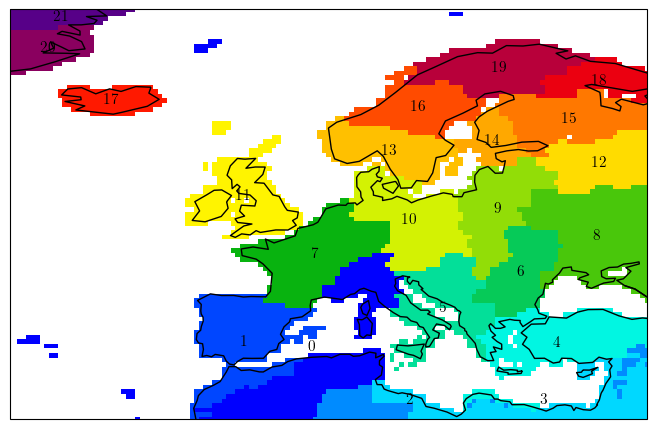

In [ ]:
clu = Clusterplot(1, 1, exp_tp.region)
cmap = colormaps.BlAqGrYeOrReVi200
ax = clu.axes[0]
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da.unstack().plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(n_clu):
    lo = clusters_da.lon.where(clusters_da==j).mean().item()
    la = clusters_da.lat.where(clusters_da==j).mean().item()
    ax.text(lo, la, f"${j}$", ha="center", va="center", fontweight="bold")

In [ ]:
compute_all_smoothed_anomalies("ERA5", "plev", "s", "6H", 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)

[########################################] | 100% Completed | 43m 20s


100%|██████████| 768/768 [1:00:00<00:00,  4.69s/it]


In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "tp", "6H", 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
100%|██████████| 83/83 [02:30<00:00,  1.81s/it]


In [ ]:
basepath = Path(f"{DATADIR}/ERA5/surf")
varnames = ["u10", "v10", "s10"]
for year, month in tqdm(product(YEARS, range(1, 13)), total=len(YEARS) * 12):
    month_str = str(month).zfill(2)
    ofiles = {varname: basepath.joinpath(f"{varname}/6H/{year}{month_str}.nc") for varname in varnames}
    if all([ofile.is_file() for ofile in ofiles.values()]):
        continue
    ds = xr.open_dataset(basepath.joinpath(f"raw/{year}{month_str}.nc"))
    ds = ds.rename(longitude="lon", latitude="lat")
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds = ds.sortby("lon")
    ds = ds.sortby("lat")
    ds["s10"] = np.sqrt(ds["u10"] ** 2 + ds["v10"] ** 2)
    for varname in varnames:
        da = ds[varname]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=xr.SerializationWarning)
            da.to_netcdf(ofiles[varname])

  0%|          | 0/768 [00:00<?, ?it/s]

100%|██████████| 768/768 [25:46<00:00,  2.01s/it]
